# COVID-19 Clinical Trials dataset: an EDA

## EDA Plan of Attack
1. **High-level understanding of data**
    - First, I will take down notes about the data from the Kaggle descriptions
    - I might also check out the associated notebook to get a better sense
2. **Brainstorm some questions** I would like to ask and analyze the data for.
    - I will probably also get inspiration from the aforementioned notebook
3. **Learn as I go!** Specifically, my goals for this EDA are:
    - get more comfortable working with the basic packages like Numpy and Pandas
    - get used to graphing using matplotlib library since that's the most common one

### Overall timeline goal
- Today is February 25, 2021; I would like to finish this project in maximum 1 week, so March 4th at the latest.

### Some quick notes on the data

- Maintained by the NIH, the database at [ClinicalTrials.gov](ClinicalTrials.gov) contains information about all privately and publicly funded clinical studies around the world.
- The particular dataset to be used consists of clinical trials related to COVID-19 studies specifically.
    - XML files: each correspond to one study; filename: `NCT########`, where the `#`'s indicate unique numerical identifiers
     of studies.
    - 1 CSV file: not as detailed as above but provides a summary.

<br>

## Higher-level analysis of data

In [41]:
# HIDE CODE

import nbformat as nbf
from glob import glob

# Collect a list of all notebooks in the content folder
notebooks = glob("../kaggle-covid-clintri/*.ipynb", recursive=True)

# Text to look for in adding tags
text_search_dict = {
    "# HIDDEN": "remove-cell",  # Remove the whole cell
    "# NO CODE": "remove-input",  # Remove only the input
    "# HIDE CODE": "hide-input"  # Hide the input w/ a button to show
}

# Search through each notebook and look for the text, add a tag if necessary
for ipath in notebooks:
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)

    for cell in ntbk.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
        if len(cell_tags) > 0:
            cell['metadata']['tags'] = cell_tags

    nbf.write(ntbk, ipath)

In [40]:
## Importing relevant modules

# libraries
import pandas as pd
import numpy as np
import os
from xml.etree import ElementTree

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Read file data
path = '../kaggle-covid-clintri/'
xml_path = path + 'covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/'
list_of_files = os.listdir(xml_path)
print('Total clinical trials:', len(list_of_files))

Total clinical trials: 5020


In [3]:
# .xml files to pandas dataframe, and save as .csv for future use.
# If already existing, load file

df_studies_pathname = '../kaggle-covid-clintri/studies_summarized.csv'

if os.path.isfile(df_studies_pathname):
    # If already saved, load the csv file
    df_studies = pd.read_csv('../kaggle-covid-clintri/studies_summarized.csv')

else:
    # .xml to pandas dataframe;
    # for most of this part I will be copying the referencing the original notebook's code because I'm not focused on learning how to do this for now.

    df_studies = pd.DataFrame()
    list_keywords = []

    for file in list_of_files:
        file_pathname = xml_path + file

        tree = ElementTree.parse(file_pathname)
        root = tree.getroot()

        # create dictionary to be turned into a df
        trial = {}

        trial['id'] = root.find('id_info').find('nct_id').text
        trial['overall_status'] = root.find('overall_status').text
        trial['study_type'] = root.find('study_type').text

        if root.find('start_date') != None:
            trial['start_date'] = root.find('start_date').text
        else:
            trial['start_date'] = ''

        if root.find('enrollment') != None:
            trial['enrollment'] = root.find('enrollment').text
        else:
            trial['enrollment'] = ''

        # modified below to output all conditions being studied, not just the first condition listed
        l_cond = []
        for cond in root.findall('condition'):
            entry = cond.text.upper().\
                replace('CORONAVIRUS INFECTIONS','CORONAVIRUS INFECTION').\
                replace('CORONA VIRUS INFECTION','CORONAVIRUS INFECTION').\
                replace('SARS-COV-2','SARS-CoV2').\
                replace('SARS-COV 2','SARS-CoV2').\
                replace('SARS-COV2','SARS-CoV2').\
                replace('COVID-19','COVID').\
                replace('COVID19','COVID').\
                replace('COVID 19','COVID').\
            l_cond.append(entry)
        trial['condition'] = '; '.join(l_cond)

        if root.find('location_countries') != None:
            trial['location_countries'] = root.find('location_countries').find('country').text.upper()
        else:
            trial['location_countries'] = ''

        # also modified below to find all interventions used
        l_inter = []
        if root.findall('intervention') != None:
            for inter in root.findall('intervention'):
                inter_entry = inter.find('intervention_name').text.upper()
                l_inter.append(inter_entry)
            trial['intervention'] = '; '.join(l_inter)
        else:
            trial['intervention'] = ''

        for entry in root.findall('keyword'):
            list_keywords.append(entry.text)

        if root.find('official_title') == None:
            trial['title'] = root.find('brief_title').text
        else:
            trial['title'] = root.find('official_title').text

        date_string = root.find('required_header').find('download_date').text
        trial['date_processed'] = date_string.replace('ClinicalTrials.gov processed this data on ', '')

        trial['sponsors'] = root.find('sponsors').find('lead_sponsor').find('agency').text

        df_studies = df_studies.append(trial, ignore_index=True)

    # save as a csv file
    df_studies.to_csv(df_studies_pathname)


In [4]:
# print the first few rows of studies dataframe and describe it
df_studies.head()
df_studies.describe()

,Unnamed: 0,enrollment
count,5020.000000,4.989000e+03
mean,2509.500000,1.981830e+04
std,1449.293506,4.333506e+05
min,0.000000,0.000000e+00
25%,1254.750000,6.000000e+01
50%,2509.500000,1.750000e+02
75%,3764.250000,5.600000e+02
max,5019.000000,2.000000e+07


In [5]:
# Load the CSV file as well
df_studies_CSV = pd.read_csv( path + 'covid19-clinical-trials-dataset/COVID clinical trials.csv')
df_studies_CSV.head()

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
1,2,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
2,3,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061
3,4,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,TMF-COVID-19,Recruiting,No Results Available,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Centre Hospitalier Régional d'Orléans|Centre d...,...,CHRO-2020-10,"May 5, 2020",May 2021,May 2021,"May 20, 2020",NaN,"June 4, 2020","CHR Orléans, Orléans, France",NaN,https://ClinicalTrials.gov/show/NCT04395924
4,5,NCT04516954,Convalescent Plasma for COVID-19 Patients,CPCP,Enrolling by invitation,No Results Available,COVID 19,Biological: Convalescent COVID 19 Plasma,Evaluate the safety|Change in requirement for ...,Vinmec Research Institute of Stem Cell and Gen...,...,ISC.20.11.1,"August 1, 2020","November 30, 2020","December 30, 2020","August 18, 2020",NaN,"August 20, 2020",Vinmec Research Institute of Stem cell and Gen...,NaN,https://ClinicalTrials.gov/show/NCT04516954


In [6]:
# What's in the CSV that's not listed in the XML data? Or at least lost in translation to dfs?
print(list(df_studies.columns))
print(list(df_studies_CSV.columns))

['Unnamed: 0', 'condition', 'date_processed', 'enrollment', 'id', 'intervention', 'location_countries', 'overall_status', 'sponsors', 'start_date', 'study_type', 'title']
['Rank', 'NCT Number', 'Title', 'Acronym', 'Status', 'Study Results', 'Conditions', 'Interventions', 'Outcome Measures', 'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Enrollment', 'Funded Bys', 'Study Type', 'Study Designs', 'Other IDs', 'Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted', 'Last Update Posted', 'Locations', 'Study Documents', 'URL']


Because we extracted only a few important categories of information from the .xml files, the `df_studies` dataframe is now
more condensed than the .csv file's summary in `df_studies_CSV`.

<br>

## Brainstorming questions I'd like to ask

To start the EDA, let's look at a few of the columns in `df_studies` (i.e. the one that's been summarized better) in
more detail!

In [7]:
list_dfColumns = list(df_studies.columns)
print(list_dfColumns)

['Unnamed: 0', 'condition', 'date_processed', 'enrollment', 'id', 'intervention', 'location_countries', 'overall_status', 'sponsors', 'start_date', 'study_type', 'title']


Some questions I would like to ask throughout this analysis:

1. Regarding the entire dataset:
    - What are the conditions (COVID- and non-COVID-related) that are being studied?
    - What status is each study in? Which of those are COVID-related?
        - From the CSV file column description in original dataset post, there is a very small number of studies with results
    available (1%). What percentage is this of the actual studies that have already been completed?
    - In which countries do studies take place? Which of those are COVID-related?
    - What are the study types used? Do COVID-related studies differ from the rest?
        - What's the distribution of enrollment sizes for study types?

2. In COVID-related studies:
    - Specific to **observational studies**:
        - length of each study (from CSV)
        - how is the outcome measured?
    - Specific to **interventional studies**:
        - length of each study (also from CSV)
        - what were some types of interventions used?
        - in drug studies, what were the top 5 most popular ones studied?
    - In the small percentage of studies that actually have results posted, were any of them focused on COVID?
        - If so, can we draw any meaningful conclusions?

<br>

## Exploratory analysis

### 1. Comparison of COVID- and non-COVID-related studies

#### Conditions being studied
First, I ask what conditions (COVID- and non-COVID-related) are being studied.

In [8]:
# Use a pie chart: must count incidences of each type

condition_counts = df_studies.condition.value_counts()
conditions_list = list(condition_counts.index)
len(conditions_list)

2464

In [9]:
# Define keywords to look for; though not ideal, I am choosing to manually define these keywords
covid_keys = [
    'covid', 'coronavirus', 'sars-cov2', '2019-ncov', 'severe acute respiratory syndrome coronavirus 2', 'ncov'
]
resp_keys = [
    'severe acute respiratory syndrome', 'sars', 'respiratory', 'pneumonia', 'cold', 'flu'
]

df_studies['study_topic'] = ['']*len(df_studies.condition)
c = 0

for cond in conditions_list:
    # from the condition chosen, parse for any of the keys string
    if any(key in cond.lower() for key in covid_keys):
        label = 'COVID-related'
    elif any(key in cond.lower() for key in resp_keys):
        label = 'Unrelated, Respiratory'
    else:
        label = 'Unrelated'
    df_studies.loc[df_studies.condition == cond, 'study_topic'] = label

df_studies[['condition','study_topic']].describe()

,condition,study_topic
count,5020,5020
unique,2464,3
top,COVID,COVID-related
freq,1448,3935


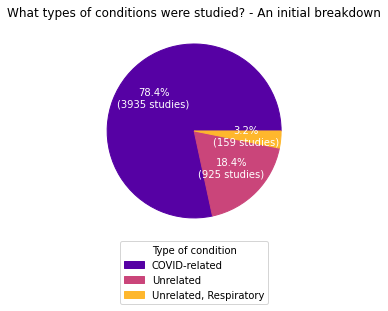

In [10]:
# Visualize the data
# TODO: (if I have time at the end) write a function for each type of chart to be formatted in a way I like

condition_detailed_counts = df_studies.study_topic.value_counts()
# print(condition_detailed_counts)

values = condition_detailed_counts.to_numpy()
labels = condition_detailed_counts.keys().to_numpy()

def pctvalue(pct, data):
    counts = int(pct/100 * np.sum(data))
    return "{:.1f}%\n({:d} studies)".format(pct, counts)

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))

wedges, texts, autotexts = ax.pie(
    values,
    textprops=dict(color='w'),
    autopct=lambda pct: pctvalue(pct, values)
)

# Colors
def data_color(datalength, mapname='plasma'):
    colours_list = plt.get_cmap(mapname)(np.linspace(0.15,0.84,datalength))
    return colours_list

colours_list = data_color(len(wedges))
for idx, wedge in enumerate(wedges):
    wedge = wedge.set_color(colours_list[idx])

ax.legend(
    wedges, labels,
    title = "Type of condition",
    loc = "center",
    bbox_to_anchor=(0,-0.1, 1,-0.1)
)

ax.set_title("What types of conditions were studied? - An initial breakdown")

plt.show()

# BONUS TODO: Make the plot interactive using plotly and enable display of all the raw condition names as listed in the datset


This pie chart shows that almost 78% of the current clinical studies available in the dataset are concerned with COVID-19.
However, the **conditions** being studied may not completely represent all studies that are related to COVID. For this,
let's examine the **study titles** to see if the `Unrelated` and `Unrelated, Respiratory` studies contain any COVID-related keywords in
their titles.

In [11]:
# Look for the COVID keywords in titles.
titles_unrelated = df_studies[df_studies['study_topic'] == 'Unrelated']['title']
titles_resp = df_studies[df_studies['study_topic'] == 'Respiratory']['title']

for title in titles_unrelated:
    if any(key in title.lower() for key in covid_keys):
        df_studies.loc[df_studies['title'] == title,'study_topic'] = 'COVID_secondary'

for title in titles_resp:
    if any(key in title.lower() for key in covid_keys):
        df_studies.loc[df_studies['title'] == title,'study_topic'] = 'COVID_secondary'

In [31]:
pd.set_option('display.max_colwidth', None)
# df_studies.style.set_properties(**{'text-align': 'left'})

for i in range(8):
    print(df_studies[df_studies['study_topic'] == 'COVID_secondary'][['condition']].iloc[i])
    print(df_studies[df_studies['study_topic'] == 'COVID_secondary'][['title']].iloc[i],'\n')

condition    RENAL CELL CARCINOMA; CANCER; HEALTHY VOLUNTEERS
Name: 34, dtype: object
title    TRACERx Renal (TRAcking Renal Cell Carcinoma Evolution Through Therapy (Rx)) CAPTURE: COVID-19 Antiviral Response in a Pan-tumour Immune Study
Name: 34, dtype: object 

condition    SYSTEMIC SCLEROSIS
Name: 69, dtype: object
title    A Phase II Randomised Study of Oral Prednisolone in Early Diffuse Cutaneous Systemic Sclerosis (Initially Double-blind, Then Switched to Open-label Because of Covid-19)
Name: 69, dtype: object 

condition    POST INTENSIVE CARE SYNDROME
Name: 75, dtype: object
title    Addressing Post-Intensive Care Syndrome Among Survivors of COVID (APICS-COVID)
Name: 75, dtype: object 

condition    B CELL ALL; B-CELL LYMPHOMA; B-CELL NON HODGKIN LYMPHOMA
Name: 125, dtype: object
title    A Phase II Study of IL-1 Receptor Antagonist Anakinra to Prevent Severe Neurotoxicity and Cytokine Release Syndrome in Patients Receiving CD19-Specific Chimeric Antigen Receptor (CAR) T Cells 

As shown here, studies that were not directly investigating symptoms/conditions associated with COVID-19 as classified
through `Conditions` category were still studying topics relevant to the disease. For example, some of them look at the secondary
physical impact (e.g. *"TRACERx Renal (TRAcking Renal Cell Carcinoma Evolution Through Therapy (Rx)) CAPTURE:
COVID-19 Antiviral Response in a Pan-tumour Immune Study"*), while others focus on psychological impacts of COVID-19 (e.g. *"
Mental Health and Its Correlates Among Chinese Adolescents Exposed to the Novel Coronavirus Disease 2019: A Longitudinal Study Protocol"*).

What do the remaining titles look like?

In [33]:
df_studies.iloc[34]

Unnamed: 0                                                                                                                                                        34
condition                                                                                                           RENAL CELL CARCINOMA; CANCER; HEALTHY VOLUNTEERS
date_processed                                                                                                                                     February 08, 2021
enrollment                                                                                                                                                     360.0
id                                                                                                                                                       NCT03226886
intervention                                                                                                                                                     NaN
location_c

In [13]:
# Some titles from studies that are still not classified as being related to COVID
titles_remaining = df_studies[df_studies['study_topic'] == ('Unrelated' or 'Respiratory')]['title']

pd.set_option('display.max_colwidth',50)
# print(titles_remaining.head())
for i in range(5,10):
    print(titles_remaining.iloc[i], '\n')

print('There are {} titles that remain unassociated with COVID-19, with some listed above.'.format(len(titles_remaining)))

Exercise in Genetic Cardiovascular Conditions (Lifestyle and Exercise in Hypertrophic Cardiomyopathy "LIVE-HCM"/Lifestyle and Exercise in the Long QT Syndrome "LIVE-LQTS" 

Uveitis/Intraocular Inflammatory Disease Biobank (iBank) 

Reshaping the Path of Vascular Cognitive Impairment With Resistance Training 

Reshaping the Path of Mild Cognitive Impairment by Refining Exercise Prescription: Understanding Training Type and Exploring Mechanisms 

Influence of Exercise on Neurocognitive Function in Breast Cancer 

There are 381 titles that remain unassociated with COVID-19, with some listed above.


Now, we can visualize the changes in an updated pie chart.

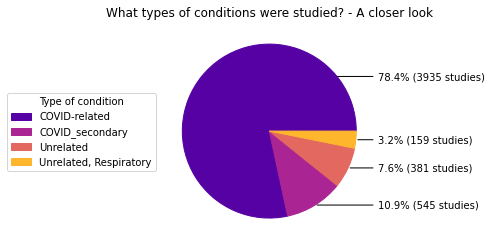

In [14]:
# Re-visualize the above data

condition_detailed_counts = df_studies.study_topic.value_counts()
# print(condition_detailed_counts)

values = condition_detailed_counts.to_numpy()
labels = condition_detailed_counts.keys().to_numpy()

def getpct(data):
    pct = data / np.sum(data) * 100
    list_pcts = []
    for idx in range(len(data)):
        list_pcts.append("{:.1f}% ({:d} studies)".format(pct[idx], data[idx]))
    return list_pcts

pcts = getpct(values)

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
wedges, texts = ax.pie(values)

# Colours
colours_list = data_color(len(wedges))
for idx, wedge in enumerate(wedges):
    wedge.set_color(colours_list[idx])

# Take some labels out of box
bbox_props = dict(boxstyle="square,pad=0.3",
                  fc="1", ec="1", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-",connectionstyle='arc3, rad=0'),
          bbox=bbox_props, zorder=0, va="center", color='k')

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ax.annotate(pcts[i], xy=(x, y), xytext=(1.25, y),
                horizontalalignment='left', **kw)

ax.legend(
    wedges, labels,
    title = "Type of condition",
    loc = "best",
    bbox_to_anchor=(-0.1,0.6,0.1,0.1)
)

ax.set_title("What types of conditions were studied? - A closer look")

plt.show()

As shown, COVID-related studies, whether directly or indirectly related, make up almost 90% of the trials listed
on the [ClinicalTrials.gov](ClinicalTrials.gov) website. Of the remainder of them, about 3% are unrelated but study
respiratory diseases such as the flu or common cold, and about 8% appear to be totally unrelated to COVID-19.

<br>

#### Study status
What status is each study currently in? We can start by plotting the `overall_status` column as a simple horizontal bar chart.

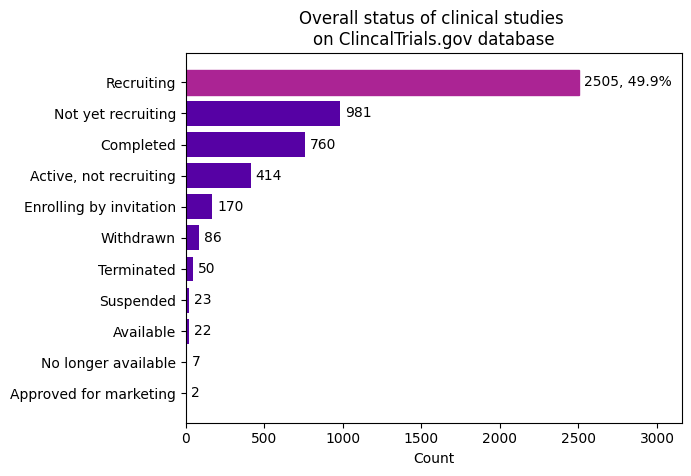

In [15]:
# Define a custom horizontal bar graph
def mybarh(catvar, varcounts, colourmap='plasma', xlabel='Count', title='', diff1stColour=True):

    plt.rcdefaults()
    fig, ax = plt.subplots()

    colours_list = data_color(len(wedges),mapname=colourmap)

    bar_elems = ax.barh(catvar, varcounts, align='center',facecolor=colours_list[0])
    if diff1stColour:
        bar_elems[0].set_color(colours_list[1])

    ax.set_yticks(range(len(catvar)))
    ax.set_yticklabels(catvar)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    _, xmax = plt.xlim()
    if diff1stColour:
        xmax *= 1.2
    else:
        xmax *= 1.1
    plt.xlim(0, xmax)

    for i, c in enumerate(varcounts):
        if diff1stColour and (c == max(varcounts)):
             ax.text(c + xmax*0.01, i,
                '{}, {:.1f}%'.format(c, c/np.sum(varcounts)*100),
                color='black', ha='left', va='center')
        else:
            ax.text(c + xmax*0.01, i,
                str(c),
                color='black', ha='left', va='center')

    return plt.show()

# Plot
status = df_studies['overall_status'].value_counts().index
counts = df_studies['overall_status'].value_counts().values

mybarh(status, counts,
       title='Overall status of clinical studies \n'
             'on ClincalTrials.gov database')

As shown, almost half of the studies are currently recruiting for participants! It would be interesting to see what proportion of
these studies are made up by COVID-related ones.

Moreover, while the current chart is displayed in the descending order of counts, we can also further categorize statuses.
Note that the `overall_status` column contains information both about **recruitment status** and **expanded access status**.
Here, "expanded access" refers to a way for patients with serious diseases or conditions who cannot participate in a clinical trial
to gain access to a medical product that has not been approved by the U.S. Food and Drug Administration (FDA).

First, the following are definitions of each category of study status:
- **Not yet recruiting:** The study has not started recruiting participants.
- **Recruiting**: The study is currently recruiting participants.
- **Enrolling by invitation**: The study is selecting its participants from a population, or group of people, decided on by the researchers in advance. These studies are not open to everyone who meets the eligibility criteria but only to people in that particular population, who are specifically invited to participate.
- **Active, not recruiting**: The study is ongoing, and participants are receiving an intervention or being examined, but potential participants are not currently being recruited or enrolled.
- **Suspended**: The study has stopped early but may start again.
- **Terminated**: The study has stopped early and will not start again. Participants are no longer being examined or treated.
- **Completed**: The study has ended normally, and participants are no longer being examined or treated (that is, the last participant's last visit has occurred).
- **Withdrawn**: The study stopped early, before enrolling its first participant.
- **Unknown**: A study on ClinicalTrials.gov whose last known status was recruiting; not yet recruiting; or active, not recruiting but that has passed its completion date, and the status has not been last verified within the past 2 years.

Overall, we could divide the above into four categories depending on the stage of a study:
`Not started`, `In preparation / Active`, `Inactive`, or `Finished`.

Secondly, the following are the definitions of each category of expanded access status; these could altogether be put under the `Expanded access` category:
- **Available**: Expanded access is currently available for this investigational treatment, and patients who are not participants in the clinical study may be able to gain access to the drug, biologic, or medical device being studied.
- **No longer available**: Expanded access was available for this intervention previously but is not currently available and will not be available in the future.
- **Temporarily not available**: Expanded access is not currently available for this intervention but is expected to be available in the future.
- **Approved for marketing**: The intervention has been approved by the U.S. Food and Drug Administration for use by the public.


In [16]:
# TODO: Sort each, and colour each bar according to the groups
df_studies['status_detail'] = ['']*len(df_studies.overall_status)
overall_status_list = list(df_studies['overall_status'].value_counts().index)
print(overall_status_list)

['Recruiting', 'Not yet recruiting', 'Completed', 'Active, not recruiting', 'Enrolling by invitation', 'Withdrawn', 'Terminated', 'Suspended', 'Available', 'No longer available', 'Approved for marketing']


In [17]:
# Group the statuses
group_labels = ['Not started', 'In prep / Active', 'Inactive', 'Finished', 'Expanded access']

# TODO: Could refactor this portion; this won't work if the number of studies in each status changes and the
# value count order changes
for i, s in enumerate(overall_status_list):
    if i in [1]:
        idx = 0
    elif i in [0,3,4]:
        idx = 1
    elif i in [5,6,7]:
        idx = 2
    elif i in [2]:
        idx = 3
    elif i in [8,9,10]:
        idx = 4
    elif s == 'Unknown':
        idx = 5
    df_studies.loc[df_studies['overall_status'] == s,'status_detail'] = group_labels[idx]

# Create a code for each study topic
df_studies['study_topic_code'] = [''] * len(df_studies['study_topic'])

# Within each group, label the COVID-related ones
df_studies.loc[df_studies.study_topic == 'COVID-related', 'study_topic_code'] = 1
df_studies.loc[df_studies.study_topic == 'COVID_secondary', 'study_topic_code'] = 1
df_studies.loc[df_studies.study_topic == 'Unrelated', 'study_topic_code'] = 0
df_studies.loc[df_studies.study_topic == 'Unrelated, Respiratory', 'study_topic_code'] = 0

# Sort within each group
grouped_status = df_studies.groupby(['status_detail','overall_status','study_topic_code'])['study_topic_code'].agg(len)\
    .unstack()

grouped_status

study_topic_code                              0       1
status_detail    overall_status                        
Expanded access  Approved for marketing     NaN     2.0
                 Available                  NaN    22.0
                 No longer available        NaN     7.0
Finished         Completed                 69.0   691.0
In prep / Active Active, not recruiting    52.0   362.0
                 Enrolling by invitation   21.0   149.0
                 Recruiting               275.0  2230.0
Inactive         Suspended                  NaN    23.0
                 Terminated                 2.0    48.0
                 Withdrawn                  3.0    83.0
Not started      Not yet recruiting       118.0   863.0

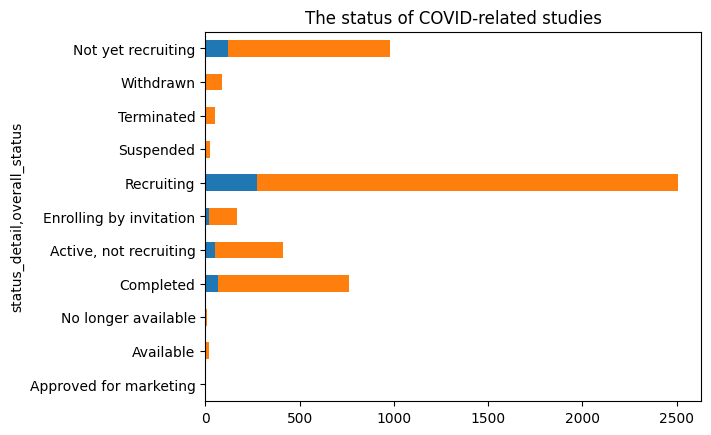

In [18]:
# Plot stacked horizontal bar chart
ax = grouped_status.plot(kind='barh', stacked=True,
                              ylabel='Study status',
                              title='The status of COVID-related studies',
                              legend=False)

# Set labels
xlabel = grouped_status.index.get_level_values(1).to_list()
_ = ax.set_yticklabels(xlabel)


# Colour each group, highlighting COVID-related ones with more saturation


#### Countries of study
In which countries do studies take place? Which of those are COVID-related ones?

In [19]:
# Horizontal bar graph
# TODO: LEVEL-UP -- draw a world map and graph dots on top of them

# list(df_studies.columns)
df_studies['location_countries'].value_counts()

UNITED STATES     1085
FRANCE             605
UNITED KINGDOM     218
ITALY              202
CANADA             177
                  ... 
LESOTHO              1
CAPE VERDE           1
GAMBIA               1
AZERBAIJAN           1
KYRGYZSTAN           1
Name: location_countries, Length: 112, dtype: int64

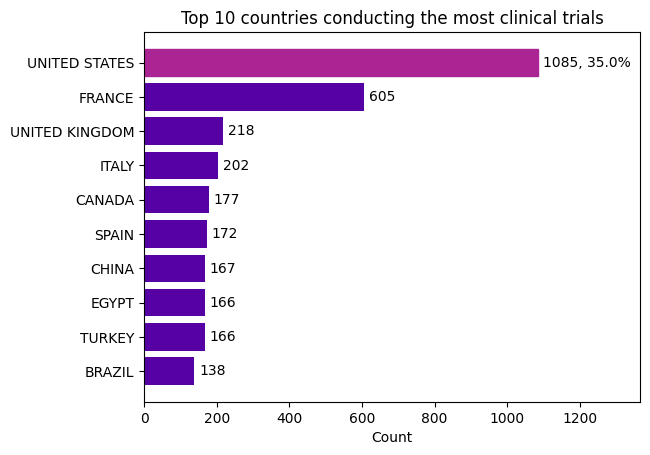

In [20]:
countries = list(df_studies['location_countries'].value_counts().index)
country_counts = list(df_studies['location_countries'].value_counts().values)

mybarh(countries[:10],country_counts[:10],
       title='Top 10 countries conducting the most clinical trials')

#### Study type: Popular study types depending on condition being studied
What are the study types used? Do COVID-related studies differ from the rest?

#### Enrollment sizes (per study type and per condition)
What's the distribution of enrollment sizes across studies?

#### Common measure of outcome being used for each study type?
What methods do each study types use to measure outcome?

#### Study results?
From CSV file, what results can we find?

<br>

### 2. A deeper dive into COVID-related studies only

#### Observational studies
- length of each study (from CSV)
- how is the outcome measured?

#### Interventional studies
- length of each study (also from CSV)
- what were some types of interventions used?
- in drug studies, what were the top 5 most popular ones studied?

#### Any meaningful conclusions?
- In the small percentage of studies that actually have results posted, were any of them focused on COVID?
- If so, can we draw any meaningful conclusions?